# 0. Import packages and librairies

In [ ]:
!pip install ucimlrepo aif360 fairlearn


In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, selection_rate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, brier_score_loss
from fairlearn.metrics import selection_rate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import joblib

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover


# 1. Import dataset

Dataset avaible at : https://archive.ics.uci.edu/dataset/117/census+income+kdd

In [ ]:
# fetch dataset
census_income_kdd = fetch_ucirepo(id=117)

# data (as pandas dataframes)
X = census_income_kdd.data.features
y = census_income_kdd.data.targets

# metadata
print(census_income_kdd.metadata)

# variable information
print(census_income_kdd.variables)

{'uci_id': 117, 'name': 'Census-Income (KDD)', 'repository_url': 'https://archive.ics.uci.edu/dataset/117/census+income+kdd', 'data_url': 'https://archive.ics.uci.edu/static/public/117/data.csv', 'abstract': 'This data set contains weighted census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 299285, 'num_features': 41, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Education Level', 'Marital Status', 'Race', 'Sex', 'Other', 'Nationality', 'Income'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C5N30T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set contains weighted census data extracted from the 

# 2. Data Pre-processing

In [ ]:
# Display the dimensions of the data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Display the first rows of features and targets
print(X.head())
print(y.head())

# Display the data types of the variables
print(X.dtypes)

# Descriptive statistics for numerical variables
print(X.describe())

# Check for missing values
print(X.isnull().sum())

# Load the data into a pandas DataFrame
df_census = census_income_kdd.data.original  # Use the raw data

print(df_census['ASEX'].unique())
print(df_census['ARACE'].unique())
print(df_census['income'].unique())


Shape of X: (199523, 41)
Shape of y: (199523, 1)
   AAGE                          ACLSWKR  ADTINK  ADTOCC  \
0    73                  Not in universe       0       0   
1    58   Self-employed-not incorporated       4      34   
2    18                  Not in universe       0       0   
3     9                  Not in universe       0       0   
4    10                  Not in universe       0       0   

                          AHGA            AHSCOL         AMARITL  \
0         High school graduate   Not in universe         Widowed   
1   Some college but no degree   Not in universe        Divorced   
2                   10th grade       High school   Never married   
3                     Children   Not in universe   Never married   
4                     Children   Not in universe   Never married   

                         AMJIND                                AMJOCC  \
0   Not in universe or children                       Not in universe   
1                  Construction   P

In [ ]:
plt.figure(figsize=(10, 9))
sns.barplot(x='AMJOCC', y='CAPGAIN', data=df_census, hue='ASEX', errorbar=None)
plt.xticks(rotation=70)
plt.title("Title")
plt.xlabel("Occupation")
plt.ylabel("Capital Gain")
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='AHGA', y='AHRSPAY', data=df_census, hue='income', errorbar=None)
plt.xticks(rotation=70)
plt.title("Distribution of Hours Worked by Education Level and Income")
plt.xlabel("Education Level")
plt.ylabel("Hours Worked per Week")
plt.show()


Transform into numeric value to reduce computational cost

In [ ]:
# Initialize the label encoder
le = LabelEncoder()

# Convert 'income' and 'ASEX' into binary variables
df_census['income'] = le.fit_transform(df_census['income'])
df_census['ASEX'] = le.fit_transform(df_census['ASEX'])

# Apply get_dummies() to convert remaining categorical variables
df_census = pd.get_dummies(df_census, drop_first=True)

# Display all columns for verification
pd.set_option('display.max_columns', 100)

# Show a preview of the DataFrame after transformation
print(df_census.head())


   AAGE  ADTINK  ADTOCC  AHRSPAY  ASEX  CAPGAIN  GAPLOSS  DIVVAL  MARSUPWRT  \
0    73       0       0        0     0        0        0       0    1700.09   
1    58       4      34        0     1        0        0       0    1053.55   
2    18       0       0        0     0        0        0       0     991.95   
3     9       0       0        0     0        0        0       0    1758.14   
4    10       0       0        0     0        0        0       0    1069.16   

   NOEMP  SEOTR  VETYN  WKSWORK  year  income  ACLSWKR_ Local government  \
0      0      0      2        0    95       1                      False   
1      1      0      2       52    94       1                      False   
2      0      0      2        0    95       1                      False   
3      0      0      0        0    94       1                      False   
4      0      0      0        0    94       1                      False   

   ACLSWKR_ Never worked  ACLSWKR_ Not in universe  ACLSWKR_ Private

# 3. Training dataset

In [ ]:
# Load the Census Income KDD dataset
census_income_kdd = fetch_ucirepo(id=117)
df_census = census_income_kdd.data.original

# Clean column names (remove spaces around names)
df_census.columns = [col.strip() for col in df_census.columns]

# Initialize the label encoder
le = LabelEncoder()

# Convert the target column 'income' into binary
df_census['income'] = le.fit_transform(df_census['income'])

# Convert categorical variables to 'category' type to optimize memory
for col in df_census.select_dtypes(include=['object']).columns:
    df_census[col] = df_census[col].astype('category').cat.codes

# Separate dependent and independent variables
X = df_census.drop(['income'], axis=1)
y = df_census['income']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

# Standardize the data (for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1),  # Parallelization
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(n_jobs=-1)  # Parallelization
}

results = {}

print("\n Starting model training...\n")
for name, model in tqdm(models.items(), desc="Training Models", leave=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"\n {name}: Accuracy = {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Display results as a DataFrame
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
df_results = df_results.sort_values(by='Accuracy', ascending=False)

print("\n Final model results:")
print(df_results.to_string(index=True))



 Starting model training...



Training Models:  17%|█▋        | 1/6 [00:01<00:08,  1.77s/it]


 Logistic Regression: Accuracy = 0.9480
              precision    recall  f1-score   support

           0       0.72      0.28      0.40      3749
           1       0.95      0.99      0.97     56108

    accuracy                           0.95     59857
   macro avg       0.84      0.64      0.69     59857
weighted avg       0.94      0.95      0.94     59857



Training Models:  33%|███▎      | 2/6 [00:07<00:16,  4.12s/it]


 Decision Tree: Accuracy = 0.9309
              precision    recall  f1-score   support

           0       0.45      0.49      0.47      3749
           1       0.97      0.96      0.96     56108

    accuracy                           0.93     59857
   macro avg       0.71      0.73      0.72     59857
weighted avg       0.93      0.93      0.93     59857



Training Models:  50%|█████     | 3/6 [00:28<00:34, 11.63s/it]


 Random Forest: Accuracy = 0.9551
              precision    recall  f1-score   support

           0       0.75      0.42      0.54      3749
           1       0.96      0.99      0.98     56108

    accuracy                           0.96     59857
   macro avg       0.86      0.71      0.76     59857
weighted avg       0.95      0.96      0.95     59857



Training Models:  67%|██████▋   | 4/6 [00:37<00:21, 10.64s/it]


 AdaBoost: Accuracy = 0.9482
              precision    recall  f1-score   support

           0       0.66      0.36      0.47      3749
           1       0.96      0.99      0.97     56108

    accuracy                           0.95     59857
   macro avg       0.81      0.67      0.72     59857
weighted avg       0.94      0.95      0.94     59857



Training Models:  83%|████████▎ | 5/6 [01:16<00:21, 21.07s/it]


 Gradient Boosting: Accuracy = 0.9552
              precision    recall  f1-score   support

           0       0.75      0.43      0.54      3749
           1       0.96      0.99      0.98     56108

    accuracy                           0.96     59857
   macro avg       0.86      0.71      0.76     59857
weighted avg       0.95      0.96      0.95     59857



Training Models: 100%|██████████| 6/6 [01:21<00:00, 13.50s/it]


 XGBoost: Accuracy = 0.9574
              precision    recall  f1-score   support

           0       0.74      0.49      0.59      3749
           1       0.97      0.99      0.98     56108

    accuracy                           0.96     59857
   macro avg       0.86      0.74      0.78     59857
weighted avg       0.95      0.96      0.95     59857


 Final model results:
                     Accuracy
XGBoost              0.957365
Gradient Boosting    0.955193
Random Forest        0.955093
AdaBoost             0.948176
Logistic Regression  0.947976
Decision Tree        0.930852


# 4. Fairness Metrics

To measure fairness in this dataset, we can use several fairness metrics, focusing on the `ASEX` (sex) and `ARACE` (race) columns as potential sensitive attributes.

1. **Demographic Parity**  
   - Measures whether the outcome distribution is the same across groups.
   - The condition for demographic parity is, for all a,b∈A\
   P(C=1|A=a)=P(C=1|A=b) \
  Demographic parity requires equal proportion of positive predictions in each group (“No Disparate Impact”).
   - Should be close to zero for fairness.

2. **Equal Opportunity Difference**  
   - Compares the true positive rates across groups.
   - Formula:  
     TPR(S = 0) - TPR(S = 1)
   - Measures if disadvantaged groups receive the same benefits.

3. **Equalized Odds**  
   - Ensures both TPR and FPR (False Positive Rate) are equal across groups.
   - The condition for True Positive parity is, for all a,b∈A \
P(C=1|Y=1,A=a)=P(C=1|Y=1,A=b).

4. **Disparate Impact Ratio**  
   - Measures how the probability of favorable outcomes differs.
   - Should be between 0.8 and 1.25 for fairness.

5. **Theil Index (Entropy-based metric)**  
   - Measures inequality in the distribution of predictions.



## Sex

In [ ]:
# Fetch dataset
census_income_kdd = fetch_ucirepo(id=117)
X = census_income_kdd.data.features
y = census_income_kdd.data.targets

# Encode categorical variables
X = X.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# Define sensitive attribute (sex)
sensitive_attr = "ASEX"  # 0: male, 1: female

# Convert variable to binary
y = y.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Compute fairness metrics
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test[sensitive_attr])
eod = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test[sensitive_attr])

# Calculate selection rates using groupby and mean
# instead of selection_rate function
selection_rate_female = y_pred[X_test[sensitive_attr] == 0].mean()
selection_rate_male = y_pred[X_test[sensitive_attr] == 1].mean()

# Disparate Impact Ratio
disparate_impact = selection_rate_female / selection_rate_male

print(f"Demographic Parity Difference: {dpd:.4f}")
print(f"Equalized Odds Difference: {eod:.4f}")
print(f"Disparate Impact Ratio: {disparate_impact:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Demographic Parity Difference: 0.0578
Equalized Odds Difference: 0.3081
Disparate Impact Ratio: 1.0618


1. Demographic Parity Difference (DPD) = 0.0584, which is rather low. This means that the probability of obtaining a positive result (`ŷ = 1`) is quite similar between men and women. This does not show an inequitable distribution.

2. Equalized Odds Difference (EOD) = 0.3139, which is rather high. This means that the classification errors (true positive rate and false positive rate) differ significantly between men and women. Here, there is a notable bias in predicting classes based on gender.

3. Disparate Impact Ratio (DIR) = 1.0624, which is close to 1, meaning that women and men have nearly the same probability of receiving a positive classification. The model is generally acceptable according to this metric.

In [ ]:
def compute_tpr_fpr(y_true, y_pred, sensitive_feature):
    results = {}
    for group in [0, 1]:  # 0: male, 1: female
        y_true_group = y_true[sensitive_feature == group]
        y_pred_group = y_pred[sensitive_feature == group]

        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()
        tpr = tp / (tp + fn)  # Sensitivity
        fpr = fp / (fp + tn)  # Fall-out

        results[group] = {"TPR": tpr, "FPR": fpr}

    return results

fairness_metrics = compute_tpr_fpr(y_test.to_numpy().flatten(), y_pred, X_test[sensitive_attr])

print(f"TPR (male) : {fairness_metrics[0]['TPR']:.4f}, TPR (female) : {fairness_metrics[1]['TPR']:.4f}")
print(f"FPR (male) : {fairness_metrics[0]['FPR']:.4f}, FPR (female) : {fairness_metrics[1]['FPR']:.4f}")

tpr_diff = abs(fairness_metrics[0]['TPR'] - fairness_metrics[1]['TPR'])
fpr_diff = abs(fairness_metrics[0]['FPR'] - fairness_metrics[1]['FPR'])

print(f"TPR Difference: {tpr_diff:.4f}")
print(f"FPR Difference: {fpr_diff:.4f}")


TPR (male) : 0.9983, TPR (female) : 0.9817
FPR (male) : 0.8224, FPR (female) : 0.5142
TPR Difference: 0.0165
FPR Difference: 0.3081


**TPR**  
The model correctly identifies high income for both groups with high accuracy.  
The difference in TPR is low, meaning that men and women have an almost equivalent chance of being correctly classified when earning more than 50k.

**FPR**  
There is an imbalance in classification errors:  
Men have a much higher false positive rate (82.44%) compared to women (51.05%).  
This means that many men with low income are incorrectly classified as having high income, whereas this happens less often for women.  

The model often incorrectly classifies women as having too low an income, which creates an injustice in decision-making.  
- This could be due to a data imbalance, where women with high income are fewer, skewing the model’s decision.  
However, the dataset relies on real-world data, highlighting the imbalances and salary inequalities. The problem is not with the model but with the disparities in the dataset, linked to real-world disparities.

A solution to address this would be to:
- **Rebalance the training data**:  
   - Check if the proportion of women with high income in the training set is too low.  
   - Perform oversampling of high-income men or undersampling of high-income women.  

- **Adjust the decision threshold**:  
   - Currently, the model is too optimistic for men.

- **Use fairness-constrained algorithms**:  
   - Add constraints on Equalized Odds.

## Race

In [ ]:
# Define sensitive groups (combination of sex + race)
X_test['Sex_Race'] = X_test['ASEX'].astype(str) + "_" + X_test['ARACE'].astype(str)

# Calculate fairness metrics for each group
dpd_race_sex = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Sex_Race'])
eod_race_sex = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test['Sex_Race'])

print(f"Demographic Parity Difference (Sex + Race): {dpd_race_sex:.4f}")
print(f"Equalized Odds Difference (Sex + Race): {eod_race_sex:.4f}")

Demographic Parity Difference (Sex + Race): 0.0706
Equalized Odds Difference (Sex + Race): 0.5652


The Demographic Parity Difference indicates a slight imbalance in the predicted outcomes across sex and race groups. \
The Equalized Odds Difference indicates a significant discrepancy in classification errors (false positives and false negatives) between the groups, suggesting the model might be biased in terms of prediction errors for certain sex and race combinations.

Mean Difference (MD)

In [ ]:
selection_female = selection_rate(y_true=y_test[X_test['ASEX'] == 1],
                                    y_pred=y_pred[X_test['ASEX'] == 1])

selection_male = selection_rate(y_true=y_test[X_test['ASEX'] == 0],
                                  y_pred=y_pred[X_test['ASEX'] == 0])

md_sex = selection_female - selection_male
print(f"Mean Difference (Sex): {md_sex:.4f}")

Mean Difference (Sex): -0.0578


Mean Absolute Error (MAE)

In [ ]:
# Calcul des erreurs par groupe
mae_sex = {
    group: mean_absolute_error(y_test[X_test["ASEX"] == group], y_pred[X_test["ASEX"] == group])
    for group in [0, 1]
}
brier_sex = {
    group: brier_score_loss(y_test[X_test["ASEX"] == group], y_pred[X_test["ASEX"] == group])
    for group in [0, 1]
}

print(f"MAE (Femmes): {mae_sex[1]:.4f}, MAE (Hommes): {mae_sex[0]:.4f}")
print(f"Brier Score (Femmes): {brier_sex[1]:.4f}, Brier Score (Hommes): {brier_sex[0]:.4f}")


MAE (Femmes): 0.0666, MAE (Hommes): 0.0215
Brier Score (Femmes): 0.0666, Brier Score (Hommes): 0.0215


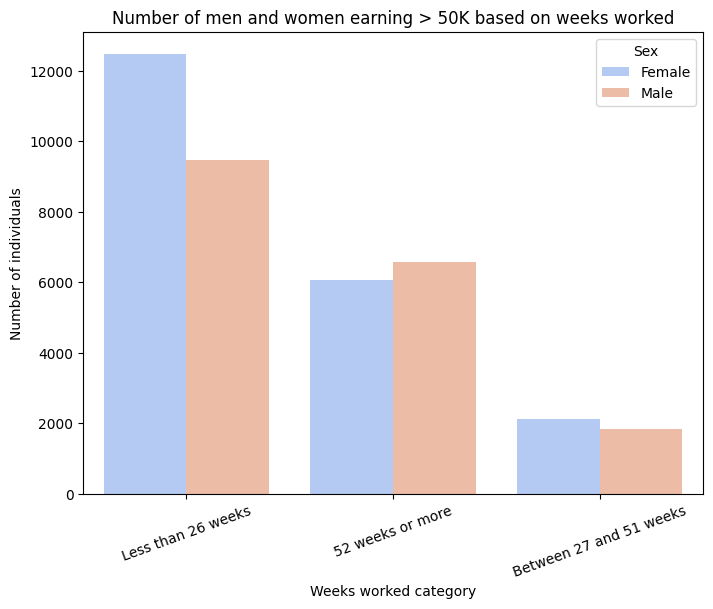

In [ ]:
# Define categories for the number of weeks worked
def categorize_weeks(weeks):
    if weeks < 26:
        return "Less than 26 weeks"
    elif 26 <= weeks <= 51:
        return "Between 27 and 51 weeks"
    else:
        return "52 weeks or more"

# Apply the categorization
X_test["Weeks_Category"] = X_test["WKSWORK"].apply(categorize_weeks)

# Create a DataFrame with sex and high income
df_fairness = pd.DataFrame({
    "Weeks_Category": X_test["Weeks_Category"],
    "Sex": X_test["ASEX"].map({0: "Female", 1: "Male"}),
    "Income > 50K": y_pred
})

# Filter only those earning more than 50K
df_fairness = df_fairness[df_fairness["Income > 50K"] == 1]

# Plot the graph
plt.figure(figsize=(8, 6))
sns.countplot(data=df_fairness, x="Weeks_Category", hue="Sex", palette="coolwarm")
plt.title("Number of men and women earning > 50K based on weeks worked")
plt.xlabel("Weeks worked category")
plt.ylabel("Number of individuals")
plt.legend(title="Sex")
plt.xticks(rotation=20)
plt.show()


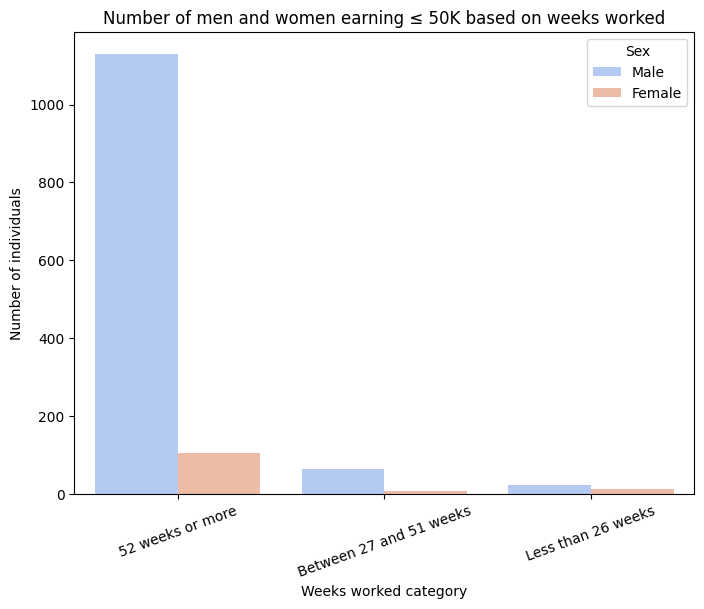

In [ ]:
def categorize_weeks(weeks):
    if weeks < 26:
        return "Less than 26 weeks"
    elif 26 <= weeks <= 51:
        return "Between 27 and 51 weeks"
    else:
        return "52 weeks or more"

X_test["Weeks_Category"] = X_test["WKSWORK"].apply(categorize_weeks)

df_fairness_low = pd.DataFrame({
    "Weeks_Category": X_test["Weeks_Category"],
    "Sex": X_test["ASEX"].map({0: "Female", 1: "Male"}),
    "Income <= 50K": (y_pred == 0)
})

df_fairness_low = df_fairness_low[df_fairness_low["Income <= 50K"] == 1]

plt.figure(figsize=(8, 6))
sns.countplot(data=df_fairness_low, x="Weeks_Category", hue="Sex", palette="coolwarm")
plt.title("Number of men and women earning ≤ 50K based on weeks worked")
plt.xlabel("Weeks worked category")
plt.ylabel("Number of individuals")
plt.legend(title="Sex")
plt.xticks(rotation=20)
plt.show()


ARACE

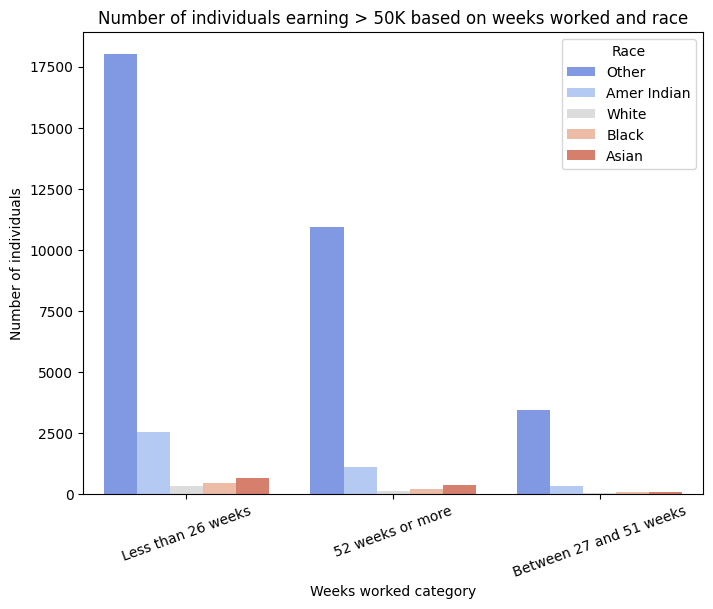

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define categories for the number of weeks worked
def categorize_weeks(weeks):
    if weeks < 26:
        return "Less than 26 weeks"
    elif 26 <= weeks <= 51:
        return "Between 27 and 51 weeks"
    else:
        return "52 weeks or more"

# Apply the categorization
X_test["Weeks_Category"] = X_test["WKSWORK"].apply(categorize_weeks)

# Create a DataFrame with ARACE (race) and high income
df_fairness = pd.DataFrame({
    "Weeks_Category": X_test["Weeks_Category"],
    "Race": X_test["ARACE"].map({0: "White", 1: "Asian", 2: "Amer Indian", 3: "Black", 4: "Other"}),
    "Income > 50K": y_pred
})

# Filter only those earning more than 50K
df_fairness = df_fairness[df_fairness["Income > 50K"] == 1]

# Plot the graph
plt.figure(figsize=(8, 6))
sns.countplot(data=df_fairness, x="Weeks_Category", hue="Race", palette="coolwarm")
plt.title("Number of individuals earning > 50K based on weeks worked and race")
plt.xlabel("Weeks worked category")
plt.ylabel("Number of individuals")
plt.legend(title="Race")
plt.xticks(rotation=20)
plt.show()


## IBM AIF360 metrics

In [ ]:
# Fetch dataset
census_income_kdd = fetch_ucirepo(id=117)
X = census_income_kdd.data.features
y = census_income_kdd.data.targets

# Encode categorical variables
X = X.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)
y = y.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# Define sensitive attribute
sensitive_attr = "ASEX"  # 0: Female, 1: Male

# Create a dataset compatible with AIF360
X['income'] = y
dataset = StandardDataset(
      X,
      label_name='income',
      favorable_classes=[1],
      protected_attribute_names=[sensitive_attr],
      privileged_classes=[[1]],
      features_to_drop=[]
  )
# Train-test split
dataset_train, dataset_test = dataset.split([0.8], shuffle=True)

# Train a classifier
clf = RandomForestClassifier()
X_train, y_train = dataset_train.features, dataset_train.labels.ravel()
X_test, y_test = dataset_test.features, dataset_test.labels.ravel()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred

# Compute fairness metrics
metric = ClassificationMetric(dataset_test, dataset_pred, unprivileged_groups=[{sensitive_attr: 0}],
                              privileged_groups=[{sensitive_attr: 1}])

dpd = metric.statistical_parity_difference()
eod = metric.equal_opportunity_difference()
disparate_impact = metric.disparate_impact()

print(f"Demographic Parity Difference: {dpd:.4f}")
print(f"Equalized Odds Difference: {eod:.4f}")
print(f"Disparate Impact Ratio: {disparate_impact:.4f}")


pip install 'aif360[inFairness]'


Demographic Parity Difference: 0.0580
Equalized Odds Difference: 0.0175
Disparate Impact Ratio: 1.0619


DPD suggests that males have a slightly higher probability of being classified as having a favorable outcome compared to females.
Our model exhibits a small bias towards sex, but the impact is not significant.

# 5. Mitigate Bias by Transforming the Original Dataset

In [ ]:
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from ucimlrepo import fetch_ucirepo

In [ ]:
!pip install aif360[inFairness] BlackBoxAuditing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 843.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00


In [ ]:
census_income_kdd = fetch_ucirepo(id=117)
X = census_income_kdd.data.features
y = census_income_kdd.data.targets

# Encode categorical variables
X = X.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)
y = y.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

sensitive_attr = "ASEX"  # 0: Female, 1: Male

X['income'] = y

dataset = StandardDataset(
      X,
      label_name='income',
      favorable_classes=[1],
      protected_attribute_names=[sensitive_attr],
      privileged_classes=[[0]],
      features_to_drop=[]
  )

# Train-test split
dataset_train, dataset_test = dataset.split([0.8], shuffle=True)

# Define privileged and unprivileged groups
unprivileged_groups = [{sensitive_attr: 0}]  # Female
privileged_groups = [{sensitive_attr: 1}]  # Male

# Train a classifier on the original dataset
clf = RandomForestClassifier()
X_train, y_train = dataset_train.features, dataset_train.labels.ravel()
X_test, y_test = dataset_test.features, dataset_test.labels.ravel()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Create a predicted dataset
dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred

# Compute fairness metrics before mitigation
metric_orig = ClassificationMetric(dataset_test, dataset_pred,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

dpd_orig = metric_orig.statistical_parity_difference()
eod_orig = metric_orig.equal_opportunity_difference()
disparate_impact_orig = metric_orig.disparate_impact()

print("Before Bias Mitigation:")
print(f"Demographic Parity Difference: {dpd_orig:.4f}")
print(f"Equalized Odds Difference: {eod_orig:.4f}")
print(f"Disparate Impact Ratio: {disparate_impact_orig:.4f}")

# Apply Disparate Impact Remover
di_remover = DisparateImpactRemover(repair_level=0.8)  # Higher value = more bias reduction
dataset_transf_train = di_remover.fit_transform(dataset_train)

# Train a classifier on the bias-mitigated dataset
X_train_transf, y_train_transf = dataset_transf_train.features, dataset_transf_train.labels.ravel()
clf.fit(X_train_transf, y_train_transf)

# Predict on the original test set
y_pred_transf = clf.predict(X_test)

# Create a new dataset with the transformed predictions
dataset_pred_transf = dataset_test.copy()
dataset_pred_transf.labels = y_pred_transf

# Compute fairness metrics after mitigation
metric_transf = ClassificationMetric(dataset_test, dataset_pred_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

dpd_transf = metric_transf.statistical_parity_difference()
eod_transf = metric_transf.equal_opportunity_difference()
disparate_impact_transf = metric_transf.disparate_impact()

print("\nAfter Bias Mitigation (Disparate Impact Remover):")
print(f"Demographic Parity Difference: {dpd_transf:.4f}")
print(f"Equalized Odds Difference: {eod_transf:.4f}")
print(f"Disparate Impact Ratio: {disparate_impact_transf:.4f}")


Before Bias Mitigation:
Demographic Parity Difference: 0.0589
Equalized Odds Difference: 0.0161
Disparate Impact Ratio: 1.0630

After Bias Mitigation (Disparate Impact Remover):
Demographic Parity Difference: 0.0605
Equalized Odds Difference: 0.0172
Disparate Impact Ratio: 1.0648


In [ ]:
census_income_kdd = fetch_ucirepo(id=117)
X = census_income_kdd.data.features
y = census_income_kdd.data.targets

# Encode categorical variables
X = X.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)
y = y.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# Define sensitive attribute related to race
sensitive_attr = "ARACE"



X['income'] = y

# distribution of ARACE, incomes
arace_income_dist = X.groupby(['ARACE', 'income']).size().unstack(fill_value=0)

print("Distribution of ARACE with income >50K (1) and <=50K (0):")
print(arace_income_dist)

dataset = StandardDataset(
      X,
      label_name='income',
      favorable_classes=[0],
      protected_attribute_names=[sensitive_attr],
      privileged_classes=[[3]],
      features_to_drop=[]
  )

# Train-test split
dataset_train, dataset_test = dataset.split([0.8], shuffle=True)

# Define privileged and unprivileged groups for race
unprivileged_groups = [{sensitive_attr: 0}]
privileged_groups = [{sensitive_attr: 3}]

# Train a classifier on the original dataset
clf = RandomForestClassifier()
X_train, y_train = dataset_train.features, dataset_train.labels.ravel()
X_test, y_test = dataset_test.features, dataset_test.labels.ravel()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Create a predicted dataset
dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred

# Compute fairness metrics before mitigation
metric_orig = ClassificationMetric(dataset_test, dataset_pred,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

dpd_orig = metric_orig.statistical_parity_difference()
eod_orig = metric_orig.equal_opportunity_difference()
disparate_impact_orig = metric_orig.disparate_impact()

print("Before Bias Mitigation:")
print(f"Demographic Parity Difference: {dpd_orig:.4f}")
print(f"Equalized Odds Difference: {eod_orig:.4f}")
print(f"Disparate Impact Ratio: {disparate_impact_orig:.4f}")

# Apply Disparate Impact Remover
di_remover = DisparateImpactRemover(repair_level=0.8)  # Higher value = more bias reduction
dataset_transf_train = di_remover.fit_transform(dataset_train)

# Train a classifier on the bias-mitigated dataset
X_train_transf, y_train_transf = dataset_transf_train.features, dataset_transf_train.labels.ravel()
clf.fit(X_train_transf, y_train_transf)

# Predict on the original test set
y_pred_transf = clf.predict(X_test)

# Create a new dataset with the transformed predictions
dataset_pred_transf = dataset_test.copy()
dataset_pred_transf.labels = y_pred_transf

# Compute fairness metrics after mitigation
metric_transf = ClassificationMetric(dataset_test, dataset_pred_transf,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

dpd_transf = metric_transf.statistical_parity_difference()
eod_transf = metric_transf.equal_opportunity_difference()
disparate_impact_transf = metric_transf.disparate_impact()

print("\nAfter Bias Mitigation (Disparate Impact Remover):")
print(f"Demographic Parity Difference: {dpd_transf:.4f}")
print(f"Equalized Odds Difference: {eod_transf:.4f}")
print(f"Disparate Impact Ratio: {disparate_impact_transf:.4f}")


Distribution of ARACE with income >50K (1) and <=50K (0):
income      0       1
ARACE                
0          49    2202
1         430    5405
2         540   19875
3          91    3566
4       11272  156093
Before Bias Mitigation:
Demographic Parity Difference: -0.0009
Equalized Odds Difference: 0.0192
Disparate Impact Ratio: 0.8874

After Bias Mitigation (Disparate Impact Remover):
Demographic Parity Difference: -0.0059
Equalized Odds Difference: -0.1026
Disparate Impact Ratio: 0.4437
